<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/covid-19predictCL/blob/master/covod_19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except OSError:
  print(tf.__version__)
finally:
  import tensorflow as tf
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Dropout
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  
  import requests as rq
  import io
  
  print(f'TF version: {tf.__version__}')
  
#  from google.colab import drive
#  drive.mount('/content/gdrive', force_remount = True, timeout_ms = 60000)


TF version: 2.2.0-rc3


In [0]:
url = 'https://raw.githubusercontent.com/GUNTERMAXIMUS/covid-19predictCL/master/covid_19_data.csv'

respond = rq.get(url).content

df_data = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7],
                      encoding = 'utf-8'
                      )

df_train = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8'
                      )

In [3]:
df = df_data[df_data['Country/Region'].str.contains('Chile')].dropna()
df_train.dropna()
print(df.isnull().any())
df.tail(10)

ObservationDate    False
Country/Region     False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool


,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
11963,04/05/2020,Chile,4471.0,34.0,618.0
12282,04/06/2020,Chile,4815.0,37.0,728.0
12602,04/07/2020,Chile,5116.0,43.0,898.0
12922,04/08/2020,Chile,5546.0,48.0,1115.0
13242,04/09/2020,Chile,5972.0,57.0,1274.0
13562,04/10/2020,Chile,6501.0,65.0,1571.0
13883,04/11/2020,Chile,6927.0,73.0,1864.0
14204,04/12/2020,Chile,7213.0,80.0,2059.0
14524,04/13/2020,Chile,7525.0,82.0,2367.0
14844,04/14/2020,Chile,7917.0,92.0,2646.0


In [4]:
gr = np.array((df.Confirmed) - (df.Recovered + df.Deaths))
growth_rate = ((gr[-1] - gr[-2]) / gr[-2]) * 100
growth_rate

2.0291568163908593

In [105]:
def growth_rate_sequence(arr):
  l = []
  c1, c2, c3 = 0, 0, 0
  for i in arr:
    x = (((arr[c1] - arr[c2]) / arr[c2]) * 100)
    l.append(x)
    c1, c2 = c1 + 1, c2 + 1
    c3 += 1
    if c3 == 1:
      c2 -= 1
  return np.array(l).reshape([-1, 1])

growth_rate_seq = (growth_rate_sequence(gr))
print(growth_rate_seq)

[[0.00000000e+00]
 [0.00000000e+00]
 [3.00000000e+02]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.00000000e+02]
 [0.00000000e+00]
 [6.25000000e+01]
 [7.69230769e+01]
 [0.00000000e+00]
 [8.69565217e+01]
 [4.18604651e+01]
 [2.13114754e+01]
 [1.09459459e+02]
 [2.96774194e+01]
 [1.84079602e+01]
 [0.00000000e+00]
 [7.98319328e+01]
 [2.40654206e+01]
 [1.73258004e+01]
 [1.76565008e+01]
 [2.31923602e+01]
 [2.36987818e+01]
 [1.45926589e+01]
 [2.20312500e+01]
 [1.79257362e+01]
 [1.16720955e+01]
 [1.10841031e+01]
 [1.24726477e+01]
 [8.21011673e+00]
 [9.70873786e+00]
 [7.76794494e+00]
 [9.67153285e+00]
 [5.90682196e+00]
 [6.04870385e+00]
 [3.08641975e+00]
 [4.98203593e+00]
 [5.88637919e+00]
 [4.82654600e+00]
 [2.56937307e+00]
 [1.68336673e+00]
 [3.94166338e-02]
 [2.02915682e+00]]


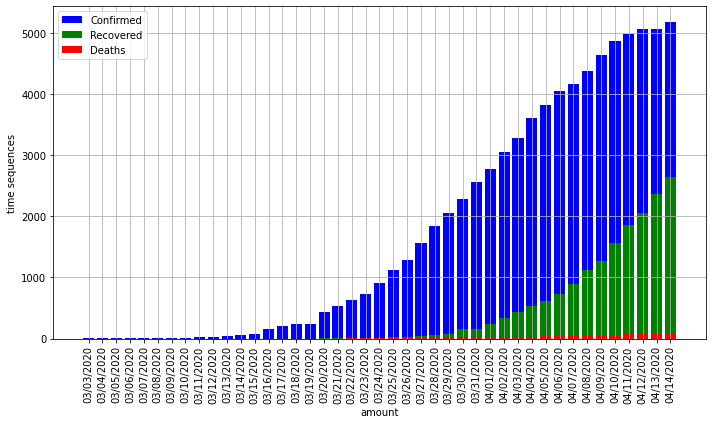

In [5]:
x = df.ObservationDate
y = (df.Confirmed) - (df.Recovered + df.Deaths)

plt.figure(figsize = (10, 6))
plt.bar(x, y, label = 'Confirmed', color = 'blue')
plt.bar(x, df.Recovered, label = 'Recovered', color = 'green')
plt.br(x, df.Deaths, label = 'Deaths', color = 'red')
#plt.stackplot(x, df.Confirmed, df.Recovered, df.Deaths)
plt.xlabel('amount', )
plt.ylabel('time sequences')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.grid(True)

plt.show()

In [0]:
dates = df.ObservationDate
confirmed = np.array([int(i) for i in y]).reshape(-1, 1)
deaths = np.array([int(i) for i in df.Deaths]).reshape(-1, 1)
recovered = np.array([int(i) for i in df.Recovered]).reshape(-1, 1)

confirmed_total = df.Confirmed.tail(1)

days = np.array([i for i in range(len(dates))]).reshape(-1, 1)
deaths_total = np.array(df.Deaths.tail(1)).reshape(-1, 1)
recovered_total = np.array(df.Recovered.tail(1)).reshape(-1, 1)

In [111]:
mortality_rate = ((df.Deaths.tail(1) / df.Confirmed.tail(1)).sum()) * 100
mort_rate_seq = np.array(((df.Deaths / df.Confirmed) * 100)).reshape([-1, 1])
print(f'Mortality rate: {mortality_rate} %')

Mortality rate: 1.1620563344701276 %


In [0]:
days_future = 30
future_forecast_days = np.array([i for i in range(len(dates) + days_future)]).reshape(-1, 1)
adjusted_dates = future_forecast_days[:-30]

In [0]:
# convert integers into date time for visualization
import datetime

start_date = datetime.datetime.strptime('03/03/2020', '%m/%d/%Y')
future_forecaste_dates = []

for i in range(len(future_forecast_days)):
  future_forecaste_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator

In [0]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3, return_train_score=True, 
                                n_jobs=-1, n_iter=30, verbose=1)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days, confirmed, test_size=0.15, shuffle=False) # confirmed -> deaths

In [12]:
svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [13]:
svm_search.best_params_

{'C': 10, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'poly', 'shrinking': True}

In [14]:
svm_confirmed = svm_search.best_estimator_
svm_prediction = svm_confirmed.predict(future_forecast_days)

print(svm_confirmed)
print(svm_prediction)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[-5.85078466e+01 -5.83960301e+01 -5.76133142e+01 -5.54887998e+01
 -5.13515876e+01 -4.45307782e+01 -3.43554724e+01 -2.01547709e+01
 -1.25777440e+00  2.30064164e+01  5.33087007e+01  9.03199778e+01
  1.34711147e+02  1.87153108e+02  2.48316759e+02  3.18873000e+02
  3.99492731e+02  4.90846850e+02  5.93606257e+02  7.08441851e+02
  8.36024532e+02  9.77025198e+02  1.13211475e+03  1.30196408e+03
  1.48724410e+03  1.68862570e+03  1.90677979e+03  2.14237725e+03
  2.39608900e+03  2.66858593e+03  2.96053893e+03  3.27261891e+03
  3.60549677e+03  3.95984341e+03  4.33632973e+03  4.73562662e+03
  5.15840498e+03  5.60533572e+03  6.07708974e+03  6.57433792e+03
  7.09775118e+03  7.64800041e+03  8.22575651e+03  8.83169038e+03
  9.46647292e+03  1.01307750e+04  1.08252676e+04  1.15506215e+04
  1.23075078e+04  1.30965971e+04  1.39185606e+04  1.47740690e+04
  1.56637

In [16]:
svm_search_2 = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3, return_train_score=True, 
                                n_jobs=-1, n_iter=10, verbose=1)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days, deaths, test_size=0.15, shuffle=False) # confirmed -> deaths

svm_search_2.fit(X_train_deaths, y_train_deaths.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [24]:
SVM_deaths = svm_search_2.best_estimator_
prediction_deaths = SVM_deaths.predict(future_forecast_days)

print(prediction_deaths)

[-1.34512135e+00 -1.34440116e+00 -1.33935983e+00 -1.32567623e+00
 -1.29902921e+00 -1.25509764e+00 -1.18956038e+00 -1.09809629e+00
 -9.76384234e-01 -8.20103074e-01 -6.24931670e-01 -3.86548886e-01
 -1.00633584e-01  2.37135376e-01  6.31079131e-01  1.08551882e+00
  1.60477558e+00  2.19317055e+00  2.85502486e+00  3.59465966e+00
  4.41639609e+00  5.32455527e+00  6.32345836e+00  7.41742648e+00
  8.61078078e+00  9.90784239e+00  1.13129325e+01  1.28303721e+01
  1.44644825e+01  1.62195847e+01  1.81000000e+01  2.01100494e+01
  2.22540541e+01  2.45363352e+01  2.69612138e+01  2.95330112e+01
  3.22560483e+01  3.51346465e+01  3.81731268e+01  4.13758103e+01
  4.47470181e+01  4.82910716e+01  5.20122916e+01  5.59149995e+01
  6.00035163e+01  6.42821632e+01  6.87552613e+01  7.34271318e+01
  7.83020957e+01  8.33844743e+01  8.86785886e+01  9.41887598e+01
  9.99193091e+01  1.05874558e+02  1.12058826e+02  1.18476437e+02
  1.25131709e+02  1.32028966e+02  1.39172527e+02  1.46566715e+02
  1.54215849e+02  1.62124

In [0]:
start_date = datetime.datetime.strptime(np.array(df.ObservationDate)[0], '%m/%d/%Y')
last_date = datetime.datetime.strptime(np.array(df.ObservationDate)[-1], '%m/%d/%Y')
pred_date = last_date + datetime.timedelta(days=days_future)

start_date_str = start_date.strftime('%d %b, %Y')
last_date_str = last_date.strftime('%d %b, %Y')
pred_date_str = pred_date.strftime('%d %b, %Y')

In [0]:
ObservationDate_datetime = [datetime.datetime.strptime(i, '%m/%d/%Y') for i in future_forecaste_dates]
ObservationDate_datetime_str = [i.strftime('%d.%m') for i in ObservationDate_datetime]

In [0]:
def one_plot_ini(p1x, p1y, title, xlabel, ylabel, legend):
  plt.figure(figsize=(15, 8))
  plt.plot(p1x, p1y)
  plt.title(label=title, size=20)
  plt.xlabel(xlabel=xlabel, size=13)
  plt.ylabel(ylabel=ylabel)
  plt.legend(legend)
  plt.xticks(size=10, rotation = 'vertical')
  plt.yticks(size=10)
  plt.grid(b = True)

def two_plots_ini(p1x, p1y, p2x, p2y, title, xlabel, ylabel, legend):
  plt.figure(figsize=(15, 8))
  plt.plot(p1x, p1y)
  plt.plot(p2x, p2y, linestyle='dashed', color='red')
  plt.title(label=title, size=20)
  plt.xlabel(xlabel=xlabel, size=13)
  plt.ylabel(ylabel=ylabel)
  plt.legend(legend)
  plt.xticks(size=10, rotation = 'vertical')
  plt.yticks(size=10)
  plt.grid(b = True)

def four_plots_ini(p1x, p1y, p2x, p2y, p3x, p3y, p4x, p4y, title, xlabel, ylabel, legend):
  plt.figure(figsize=(15, 8))
  plt.plot(p1x, p1y)
  plt.plot(p2x, p2y)
  plt.plot(p3x, p3y, linestyle='dashed', color='red')
  plt.plot(p4x, p4y, linestyle='dashed', color='purple')
  plt.title(label=title, size=20)
  plt.xlabel(xlabel=xlabel, size=13)
  plt.ylabel(ylabel=ylabel)
  plt.legend(legend)
  plt.xticks(size=10, rotation = 'vertical')
  plt.yticks(size=10)
  plt.grid(b = True)

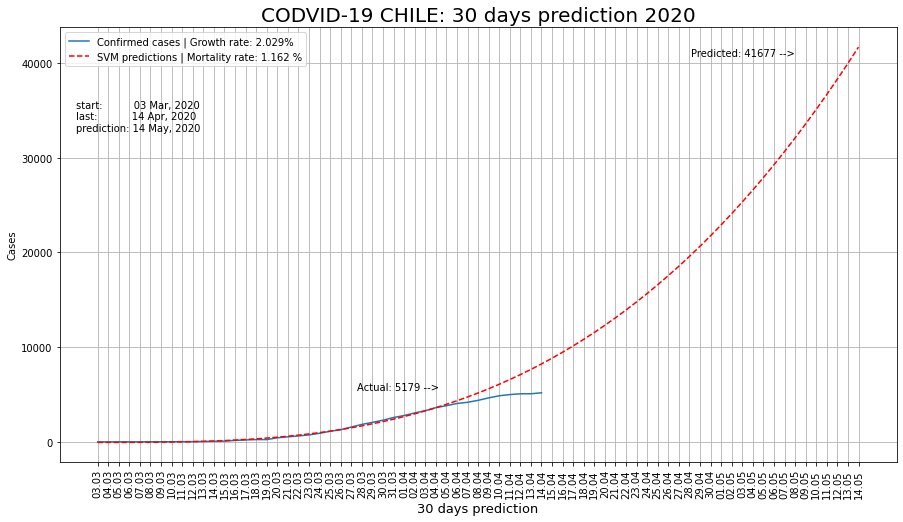

In [141]:
title = 'CODVID-19 CHILE: 30 days prediction 2020'
legend_confirmed = [f'Confirmed cases | Growth rate: {round(growth_rate, 3)}%', f'SVM predictions | Mortality rate: {round(mortality_rate, 3)} %']
two_plots_ini(adjusted_dates, y,
              ObservationDate_datetime_str, svm_prediction,
              title,
              '30 days prediction',
              'Cases',
              legend_confirmed)

plt.figtext(x = 0.14, y = 0.70, s = f'start:          {start_date_str}\nlast:           {last_date_str} \nprediction: {pred_date_str}')
plt.figtext(x = 0.40, y = 0.25, s = f'Actual: {int(np.array(df.Confirmed - (df.Deaths + df.Recovered))[-1])} -->')
plt.figtext(x = 0.71, y = 0.83, s = f'Predicted: {int(round(svm_prediction[-1]))} -->')

plt.show()

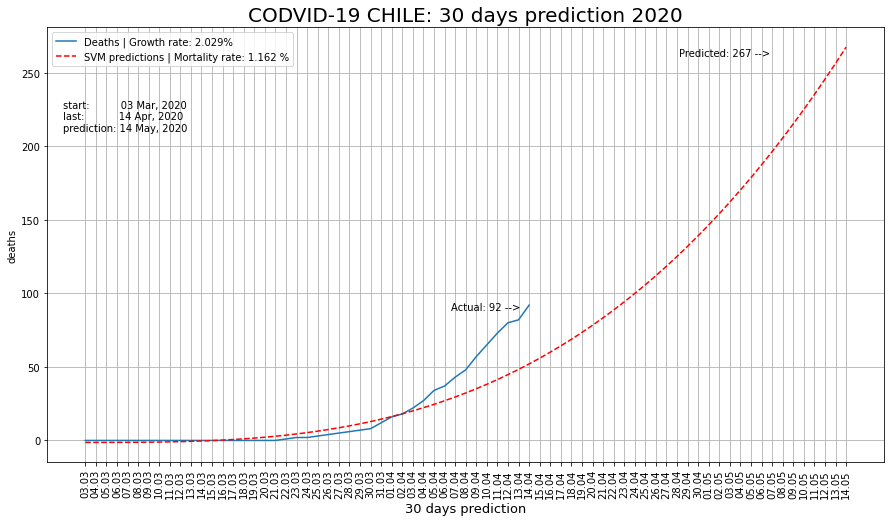

In [151]:
legend_death = [f'Deaths | Growth rate: {round(growth_rate, 3)}%', f'SVM predictions | Mortality rate: {round(mortality_rate, 3)} %']
two_plots_ini(adjusted_dates, deaths,
             ObservationDate_datetime_str, prediction_deaths,
             title,
             '30 days prediction',
             'deaths',
             legend_death)

plt.figtext(x = 0.14, y = 0.70, s = f'start:          {start_date_str}\nlast:           {last_date_str} \nprediction: {pred_date_str}')
plt.figtext(x = 0.499, y = 0.389, s = f'Actual: {int(np.array(df.Deaths)[-1])} -->')
plt.figtext(x = 0.71, y = 0.83, s = f'Predicted: {int(round(prediction_deaths[-1]))} -->')

plt.show()

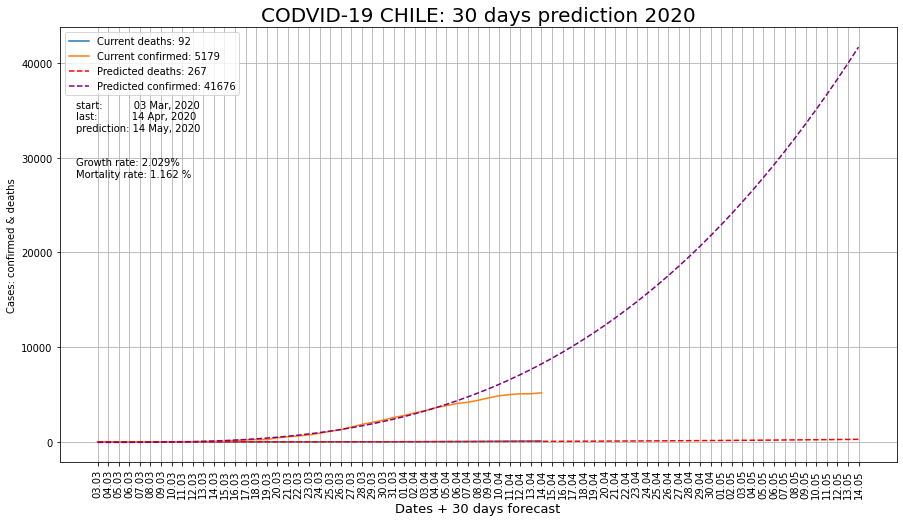

In [153]:
legend_confirmed_deaths = [f'Current deaths: {int(deaths[-1])}',
                          f'Current confirmed: {int(confirmed[-1])}',
                          f'Predicted deaths: {int(prediction_deaths[-1])}',
                          f'Predicted confirmed: {int(svm_prediction[-1])}']

four_plots_ini(adjusted_dates, deaths,
               adjusted_dates, y,
               ObservationDate_datetime_str, prediction_deaths,
               ObservationDate_datetime_str, svm_prediction,
               title,
               'Dates + 30 days forecast',
               'Cases: confirmed & deaths',
               legend_confirmed_deaths)

plt.figtext(x = 0.14, y = 0.70, 
            s = f'start:          {start_date_str}\nlast:           {last_date_str} \nprediction: {pred_date_str}')

plt.figtext(x = 0.14, y = 0.62, 
            s = f'Growth rate: {round(growth_rate, 3)}%\nMortality rate: {round(mortality_rate, 3)} %')

plt.show()

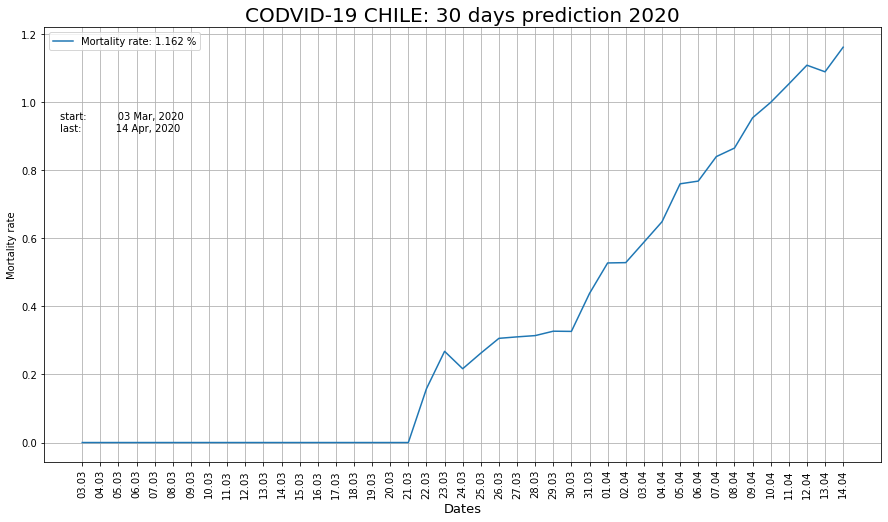

In [173]:
legend_mort_rate = [f'Mortality rate: {round(mortality_rate, 3)} %']

one_plot_ini(ObservationDate_datetime_str[:len(adjusted_dates)], mort_rate_seq,
            title,
             'Dates',
             'Mortality rate',
             legend_mort_rate)

plt.figtext(x = 0.14, y = 0.70, 
            s = f'start:          {start_date_str}\nlast:           {last_date_str}')
plt.show()

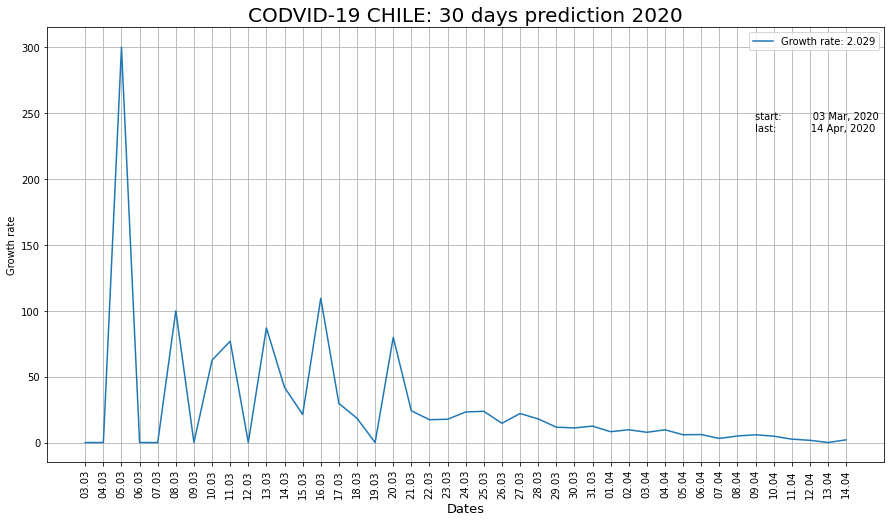

In [179]:
legend_growth = [f'Growth rate: {round(growth_rate, 3)}']
one_plot_ini(ObservationDate_datetime_str[:len(adjusted_dates)], growth_rate_seq,
             title,
             'Dates',
             'Growth rate',
             legend_growth)

plt.figtext(x = 0.78, y = 0.70, 
            s = f'start:          {start_date_str}\nlast:           {last_date_str}')

plt.show()

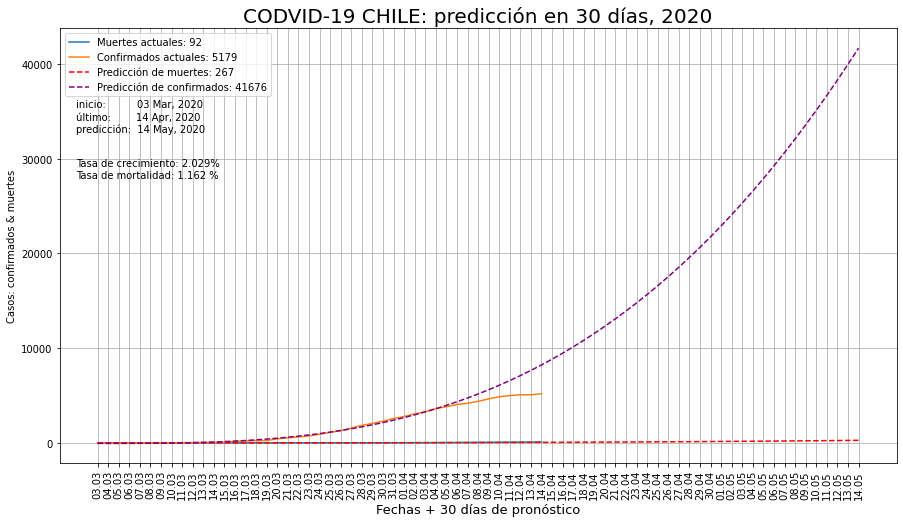

In [180]:
leyenda_confirmados_muertes = [f'Muertes actuales: {int(deaths[-1])}',
                                f'Confirmados actuales: {int(confirmed[-1])}',
                                f'Predicción de muertes: {int(prediction_deaths[-1])}',
                                f'Predicción de confirmados: {int(svm_prediction[-1])}']

four_plots_ini(adjusted_dates, deaths,
               adjusted_dates, y,
               ObservationDate_datetime_str, prediction_deaths,
               ObservationDate_datetime_str, svm_prediction,
               'CODVID-19 CHILE: predicción en 30 días, 2020',
               'Fechas + 30 días de pronóstico',
               'Casos: confirmados & muertes',
               leyenda_confirmados_muertes)

plt.figtext(x = 0.14, y = 0.70, 
            s = f'inicio:          {start_date_str}\núltimo:        {last_date_str} \npredicción:  {pred_date_str}')

plt.figtext(x = 0.14, y = 0.62, 
            s = f'Tasa de crecimiento: {round(growth_rate, 3)}%\nTasa de mortalidad: {round(mortality_rate, 3)} %')

plt.show()